# Compute Hydrodynamic equations in 3+1 formalism

In this file, we compute  the 3+1 form of the conservative variables, fluxes and sources of the hydrodynamic relativistic equations. The formalism is taken from the book *Introduction to 3+1 Numerical Relativity* by *Miguel Alcubierre*.

## Import packages

1. Sympy is used to simplification.

In [1]:
from sympy import *
from gravipy import *
init_printing(use_unicode=True)

type_file = 'fortran'

if type_file == 'c':
    from sympy.printing import StrPrinter
    StrPrinter._print_Pow = lambda self, expr: "pow(%s, %s)" % (self._print(expr.base), self._print(expr.exp))

## Metric conversion

In this section, you choose which coordiante system (**cart, cyll, sphr**) you want to used for the predefined metrics:
1. Minkowski (**Mink**)
$$\mathrm{d}s^2 = - \mathrm{d}t^2 + \mathrm{d}x^2 + \mathrm{d}y^2 + \mathrm{d}z^2.$$

2. Schwarzschild (**Schw**)
$$\mathrm{d}s^2 = - \left( 1 - \frac{2M}{r} \right) \mathrm{d}t^2 + \frac{1}{1 - \frac{2M}{r}} \mathrm{d}r^2 + r^2 \left( \mathrm{d}\theta^2 + \sin^2 \theta \mathrm{d}\phi \right).$$

3. Schwarzschild -> Ingoing Eddington-Finkelstein (**EF**)
$$\mathrm{d}s^2 = - \left( 1 - \frac{2M}{r} \right) \mathrm{d}{t'}^2 + \frac{4M}{r} \mathrm{d}t' \mathrm{d}r +\left( 1 + \frac{2M}{r}\right) \mathrm{d}r^2 + r^2 \left( \mathrm{d}\theta^2 + \sin^2 \theta \mathrm{d}\phi \right).$$

The default coordinate system is spherical, even in the Minkowski case, a conversion to cartesian or cylindrical is performed. 

Any other metric, like the Kerr black hole one, could be added. Each new parameter included, like the black hole mass *M* should be defined as a symbols using the *symbols* function.

After the definition, the metric tensor $g_{\mu \nu}$ (**G**), its inverse $g^{\mu \nu}$ (**iG**) and its determinant $\mathrm{det}(g)$ (**det**) are computed. As well as the 3D-metric $\gamma_{ij}$ (**Y, iY** and **dety**).

Units are taken to be $G = \mathrm{c} = 1$.

In [21]:
# Choose metric
t = symbols('t', positive = True, real = True)
r = symbols('r', positive = True, real = True)
theta = symbols('theta', real = True)
phi = symbols('phi',positive = True, real = True)
metric = 'BL'
coords = 'sphr'

if metric == 'Mink':
    M     = symbols('M', positive = True, real = True)
    G     = Matrix([[-1,0,0,0],[0,1,0,0],[0,0,r**2,0],[0,0,0,r**2*sin(theta)**2]])
    iG    = simplify(G**-1)
    detg  = simplify(G.det())
    Y     = G[1:4,1:4]
    iY    = simplify(Y**-1)
    dety  = simplify(Y.det())
elif metric == 'Schw':
    M     = symbols('M', positive = True, real = True)
    G     = Matrix([[-(1 - 2*M/r),0,0,0],[0,1/(1 - 2*M/r),0,0],[0,0,r**2,0],[0,0,0,r**2*sin(theta)**2]])
    iG    = simplify(G**-1)
    detg  = simplify(G.det())
    Y     = G[1:4,1:4]
    iY    = simplify(Y**-1)
    dety  = simplify(Y.det())
elif metric == 'EF':
    M     = symbols('M', positive = True, real = True)
    G     = Matrix([[-(1 - 2*M/r),2*M/r,0,0],[2*M/r,1 + 2*M/r,0,0],[0,0,r**2,0],[0,0,0,r**2*sin(theta)**2]])
    iG    = simplify(G**-1)
    detg  = simplify(G.det())
    Y     = G[1:4,1:4]
    iY    = simplify(Y**-1)
    dety  = simplify(Y.det())
elif metric == 'KS':
    M     = symbols('M', positive = True, real = True)
    a     = symbols('a', real = True)
    Sigma, Delta, A = symbols('Sigma, Delta, A', real = True)
    #Sigma = r**2 + a**2*cos(theta)**2
    #Delta = r**2 - 2*M*r + a**2
    #A     = Sigma**2 + a**2*sin(theta)**2*(Sigma + 2*M*r)
    alfa  = 1/sqrt(1 + 2*M*r/Sigma)
    b1    = (2*M*r/Sigma)/(1 + 2*M*r/Sigma)
    b2    = 0.0
    b3    = 0.0
    y11   = 1 + 2*M*r/Sigma
    y12   = 0.0
    y13   = -a*sin(theta)**2*(1 + 2*M*r/Sigma)
    y21   = y12
    y22   = Sigma
    y23   = 0.0
    y31   = y13
    y32   = y23
    y33   = A*sin(theta)**2/Sigma
    bb    = y11*b1*b1
    G     = Matrix([[-alfa**2 + bb, b1, b2, b3],[b1,y11,y12,y13],[b2,y21,y22,y23],[b3,y31,y32,y33]])
    G     = simplify(G)
    iG    = simplify(G**-1)
    detg  = simplify(G.det())
    Y     = G[1:4,1:4]
    iY    = simplify(Y**-1)
    dety  = simplify(Y.det())
elif metric == 'BL':
    M     = symbols('M', positive = True, real = True)
    a     = symbols('a', real = True)
    Sigma, Delta, rho2 = symbols('Sigma, Delta, rho2', real = True)
    g00   = -(1 - 2*M*r/(r*r + a*a*cos(theta)*cos(theta)))
    g01   = 0
    g02   = 0
    g03   = -2*M*r*a*sin(theta)*sin(theta)/(r*r + a*a*cos(theta)*cos(theta))
    g10   = g01
    g11   = (r*r + a*a*cos(theta)*cos(theta))/(r*r - 2*M*r + a*a)
    g12   = 0
    g13   = 0
    g20   = g02
    g21   = g12
    g22   = r*r + a*a*cos(theta)*cos(theta)
    g23   = 0
    g30   = g03
    g31   = g13
    g32   = g23
    g33   = (r*r + a*a + 2*M*r*a*a*sin(theta)*sin(theta)/(r*r + a*a*cos(theta)*cos(theta)))*sin(theta)*sin(theta)
    G     = Matrix([[g00, g01, g02, g03],[g10,g11,g12,g13],[g20,g21,g22,g23],[g30,g31,g32,g33]])
    G     = simplify(G)
    iG    = simplify(G**-1)
    detg  = simplify(G.det())
    Y     = G[1:4,1:4]
    iY    = simplify(Y**-1)
    dety  = simplify(Y.det())

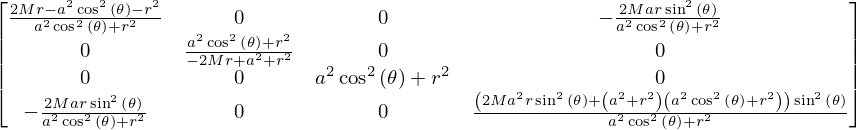

In [22]:
G

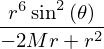

In [23]:
dety.replace(A,Sigma**2 + a**2*sin(theta)**2*(Sigma + 2*M*r)).replace(Sigma,r**2 + a**2*cos(theta)**2).replace(a,0.0)

In [24]:
#bla = simplify(diff(alfa.replace(Sigma,r**2 + a**2*cos(theta)**2),theta))
bla = diff(Y[2,2].replace(A,Sigma**2 + a**2*sin(theta)**2*(Sigma + 2*M*r)).replace(Sigma,r**2 + a**2*cos(theta)**2),theta)

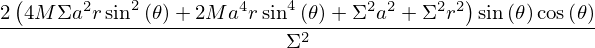

In [25]:
simplify(bla.replace(a*a*cos(theta)*cos(theta) + r*r,Sigma).replace(2*M*r + a*a*cos(theta)*cos(theta) + r*r,2*M*r + Sigma))

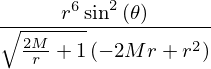

In [26]:
(alfa*dety).replace(A,Sigma**2 + a**2*sin(theta)**2*(Sigma + 2*M*r)).replace(Sigma,r**2 + a**2*cos(theta)**2).replace(a,0.0)

In this part the coordinate transformation is performed using:
$$g_{\mu' \nu'} = \frac{\partial x^\mu}{\partial x^{\mu'}} \frac{\partial x^\nu}{\partial x^{\nu'}} g_{\mu \nu},$$
where
$$x^\mu = (t,r,\theta,\phi),$$
and
$$x^{\mu'} = (t,x,y,z),$$
or
$$x^{\mu'} = (t,R,z,\phi).$$

In [27]:
if coords == 'cart':
    t = t
    x = r*sin(theta)*cos(phi)
    y = r*sin(theta)*sin(phi)
    z = r*cos(theta)
   
    CART = Matrix([t,x,y,z])
    SPHR = Matrix([t,r,theta,phi])
   
    J  = simplify(CART.jacobian(SPHR))
    iJ = simplify(J**-1)
    
    G  = iJ.T * G * iJ
    iG = J * iG * J.T
    
    CART = Matrix([x,y,z])
    SPHR = Matrix([r,theta,phi])
    
    J  = simplify(CART.jacobian(SPHR))
    iJ = simplify(J**-1)
    
    Y  = iJ.T * Y * iJ
    iY = J * iY * J.T  
    
elif coords == 'cyll':
    t   = t
    R   = r*sin(theta)
    z   = r*cos(theta)
    phi = phi
    
    CYLL = Matrix([t,R,z,phi])
    SPHR = Matrix([t,r,theta,phi])
    
    J  = simplify(CYLL.jacobian(SPHR))
    iJ = simplify(J**-1)
    
    G  = iJ.T * G * iJ
    iG = J * iG * J.T
    
    CYLL = Matrix([R,z,phi])
    SPHR = Matrix([r,theta,phi])
    
    J  = simplify(CYLL.jacobian(SPHR))
    iJ = simplify(J**-1)
    
    Y  = iJ.T * Y * iJ
    iY = J * iY * J.T    

Simplification of the 4D and 3D metrics.

In [28]:
G  = simplify(G)
iG = simplify(iG)

if coords == 'cyll':
    detg = simplify(G.det())

In [29]:
Y  = simplify(Y)
iY = simplify(iY)

if coords == 'cart':
    dety = simplify(expand_trig(Y.det()))
if coords == 'cyll':
    dety = simplify(Y.det())

Definition of the coordinates to use as symbolic variables.

In [30]:
if coords == 'cart':
    t, x, y,z = symbols('t, x, y, z', real = True) # define some symbolic variables
    X = Coordinates('X',[t, x, y, z]) 
elif coords == 'cyll':
    t, R, z, phi = symbols('t, R, z, phi', real = True)
    X = Coordinates('X',[t,R,z,phi])  
elif coords == 'sphr':
    X = Coordinates('X',[t,r,theta,phi])

Converting $(r,\theta,\phi) \rightarrow (x,y,z)$ or $(R,z,\phi)$.

In [31]:
if coords == 'cart':
    G = expand_trig(G)
    G = G.replace(sin(phi),y/(r*sin(theta)))
    G = G.replace(cos(phi),x/(r*sin(theta)))
    G = G.replace(cos(theta),z/r)
    G = G.replace(sin(theta)**2,1 - z**2/r**2)
    G = simplify(G)
    G = factor(G)
    G = G.replace(r**2,x**2 + y**2 + z**2)
    G = simplify(G)
    G = G.replace(r,sqrt(x**2 + y**2 + z**2))
    G = simplify(G)
    
    iG = expand_trig(iG)
    iG = iG.replace(sin(phi),y/(r*sin(theta)))
    iG = iG.replace(cos(phi),x/(r*sin(theta)))
    iG = iG.replace(cos(theta),z/r)
    iG = iG.replace(sin(theta)**2,1 - z**2/r**2)
    iG = iG.replace(r,sqrt(x**2 + y**2 + z**2))
    iG = simplify(iG)

    Y = expand_trig(Y)
    Y = Y.replace(sin(phi),y/(r*sin(theta)))
    Y = Y.replace(cos(phi),x/(r*sin(theta)))
    Y = Y.replace(cos(theta),z/r)
    Y = Y.replace(sin(theta)**2,1 - z**2/r**2)
    Y = simplify(Y)
    Y = factor(Y)
    Y = Y.replace(r**2,x**2 + y**2 + z**2)
    Y = simplify(Y)

    iY = expand_trig(iY)
    iY = iY.replace(sin(phi),y/(r*sin(theta)))
    iY = iY.replace(cos(phi),x/(r*sin(theta)))
    iY = iY.replace(sin(theta)**2,1 - z**2/r**2)
    iY = iY.replace(cos(theta),z/r)
    iY = simplify(iY)
    iY = factor(iY)
    iY = iY.replace(r**2,x**2 + y**2 + z**2)
    iY = simplify(iY)
    
    detg = simplify(G.det())
    detg = simplify(detg)
    detg = detg.replace(x**2 + y**2 + z**2,r**2)

elif coords == 'cyll':
    G = expand_trig(G)
    G = G.replace(sin(theta),R/r)
    G = G.replace(cos(theta),z/r)
    G = G.replace(sin(2*theta),R*z/r**2)
    G = G.replace(r,sqrt(R**2 + z**2))
    G = simplify(G)

    iG = iG.replace(sin(theta),R/r)
    iG = iG.replace(cos(theta),z/r)
    iG = iG.replace(sin(2*theta),R*z/r**2)
    iG = iG.replace(r,sqrt(R**2 + z**2))
    iG = simplify(iG)

    Y = expand_trig(Y)
    Y = Y.replace(sin(theta),R/r)
    Y = Y.replace(cos(theta),z/r)
    Y = Y.replace(sin(2*theta),R*z/r**2)
    Y = simplify(Y)

    iY = expand_trig(iY)
    iY = iY.replace(sin(theta),R/r)
    iY = iY.replace(cos(theta),z/r)
    iY = iY.replace(sin(2*theta),R*z/r**2)
    iY = simplify(iY)

    detg = detg.replace(sin(theta),R/r)
    detg = detg.replace(cos(theta),z/r)

    dety = dety.replace(sin(theta),R/r)
    dety = dety.replace(cos(theta),z/r) 

Define **g_cov**$= g_{\mu \nu}$, **g_con**$= g^{\mu \nu}$, **y_cov**$= \gamma_{ij}$ and **y_con**$= \gamma^{ij}$.
We mantain the definition of $r^2 = x^2 + y^2 + z^2$ or $r^2 = R^2 + z^2$, in order to save space.

In [32]:
g_cov = G
g_con = iG

In [33]:
y_cov = Y
y_con = iY

if coords == 'cart':
    y_cov = y_cov.replace(x**2 + y**2 + z**2, r**2)
    y_cov = simplify(y_cov)
    y_cov = factor(y_cov)
    y_cov = y_cov.replace(2*M*r**2 - 2*M*y**2 - 2*M*z**2 + r**3,2*M*x**2 + r**3 )
    y_cov = simplify(y_cov)
    y_cov = y_cov.replace(2*M*r**2 - 2*M*y**2 - 2*M*z**2 + r**3,2*M*x**2 + r**3 )
    y_cov = simplify(y_cov)
    y_cov = y_cov.replace(2*M*y**2 + 2*M*z**2 - r**3,2*M*r**2 - 2*M*x**2 - r**3 )
    y_cov = simplify(y_cov)
    
    y_con = y_con.replace(x**2 + y**2 + z**2, r**2)
    y_con = simplify(y_con)
    y_con = y_con.replace(x**2 + y**2, r**2 - z**2)
    y_con = simplify(y_con)
    y_con = factor(y_con)
    y_con = y_con.replace(-2*M*r**2 + 2*M*y**2 + 2*M*z**2 + r**3,-2*M*x**2 + r**3 )
    y_con = simplify(y_con)
    y_con = y_con.replace(2*M*y**2 + 2*M*z**2 + r**3,2*M*r**2 - 2*M*x**2 + r**3 )

elif coords == 'cyll':
    y_cov = y_cov.replace(R**2 + z**2, r**2)
    y_cov = simplify(y_cov)
    y_con = y_con.replace(R**2 + z**2, r**2)
    y_con = simplify(y_con)

## Define 3+1 gauge functions

In the 3+1 formalism, the general metric is written as
$$\mathrm{d}s^2 = -\left( \alpha^2 - \beta_i \beta^i \right) \mathrm{d}t^2 + 2\beta_i \mathrm{d}t \mathrm{d}x^i + \gamma_{ij} \mathrm{d}x^i \mathrm{d}x^j,$$
where $\alpha$ is the *lapse function*, $\beta_i$ is the 3D-shift vector and, as was already defined, $\gamma_{ij}$ is the 3D-metric.

By comparing with $g_{\mu \nu}$, is easy to show that
$$\alpha = - \frac{\mathrm{det}(g)}{\mathrm{det}(\gamma)}$$,
and
$$ \beta_i = g_{0i}$$.

It is important to say that three-dimensional vector indices are contracted with $\gamma_{ij}$, i.e., $\beta^i = \gamma^{ij} \beta_j$.

In [34]:
a2  = cancel(detg/dety)
a   = sqrt(-a2)
ia2 = cancel(1/a2)
ia  = sqrt(-ia2)

#Bv0, Bv1, Bv2 = symbols('Bc0, Bc1, Bc2', real = True)
#Bn0, Bn1, Bn2 = symbols('Bn0, Bn1, Bn2', real = True)

#B_cov = Matrix([Bv0,Bv1,Bv2])
#B_con = Matrix([Bn0,Bn1,Bn2])
B_cov = G[0,1:4]
B_con = y_con * B_cov.T

In [35]:
if coords == 'cart':
    B_cov = B_cov.replace(x**2 + y**2 + z**2,r**2)
    B_con = B_con.replace(r**2,x**2 + y**2 + z**2)
    B_con = factor(B_con)
    B_con = simplify(B_con)
    B_con = B_con.replace(x**2 + y**2 + z**2,r**2)
elif coords == 'cyll':
    B_cov = B_cov.replace(R**2 + z**2,r**2)
    B_cov = simplify(B_cov)
    B_con = B_con.replace(R**2 + z**2,r**2)
    B_con = simplify(B_con)

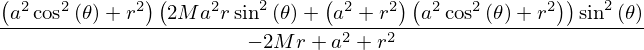

In [36]:
dety

In [42]:
bla = dety.replace(a**2*cos(theta)**2,rho2)

In [43]:
ccode(bla)

'(pow(a, 2)*pow(cos(theta), 2) + pow(r, 2))*(2*M*pow(a, 2)*r*pow(sin(theta), 2) + (pow(a, 2) + pow(r, 2))*(pow(a, 2)*pow(cos(theta), 2) + pow(r, 2)))*pow(sin(theta), 2)/(-2*M*r + pow(a, 2) + pow(r, 2))'

In [ ]:
a = a.replace(r,sqrt(x*x + y*y + z*z))

In [ ]:
daR = simplify(diff(a,z))
daR.replace(x*x + y*y + z*z,r*r)

In [ ]:
y_cov = y_cov.replace(r,sqrt(x*x + y*y + z*z))

In [ ]:
y_cov = simplify(y_cov)

In [ ]:
dy = simplify(diff(y_cov,y))
simplify(dy.replace(x*x + y*y + z*z,r*r))

## 3D- Velocity

Here we define the 3D velocity $v_i = (u,v,w)$, which corresponds to $(v_x = \dot{x}, v_y = \dot{y}, v_z = \dot{z})$, $(v_R = \dot{R}, v_z = \dot{z}, v_\phi = R\dot{\phi})$ and $(v_r = \dot{r}, v_\theta = r\dot{\theta}, v_\phi = r\sin \theta \dot{\phi})$ for the cartesian, cylindrical and spherical coordinate systems, respectively.

We also define the symbolic momentum 3D-vector $m_i = (m,n,o)$.

In [ ]:
u, v, w = symbols('u, v, w')
m, n, o         = symbols('m, n, o')

V_cov = Matrix([u,v,w])
V_con = Matrix([0,0,0])

V_con = y_con * V_cov

VV = V_cov.T * V_con

m_cov = Matrix([m,n,o])
m_con = Matrix([0,0,0])

m_con = y_con * m_cov

mm = m_cov.T * m_con

In [ ]:
if coords == 'cart':
    V_cov = V_cov.replace(x**2 + y**2 + z**2,r**2)
    V_con = V_con.replace(x**2 + y**2 + z**2,r**2)
    
    V_con = V_con.replace(-2*M*r**2 + 2*M*y**2 + 2*M*z**2,- 2*M*x**2)

elif coords == 'cyll':
    V_cov = V_cov.replace(R**2 + z**2,r**2)
    V_cov = simplify(V_cov)
    V_con = V_con.replace(R**2 + z**2,r**2)
    V_con = simplify(V_con)

Here we define the symbolic *Lorentz factor* $W$ and the 4-velocity
$$U^\mu = \left[ \frac{W}{\alpha}, W \left( v^i - \frac{\beta^i}{\alpha} \right) \right],$$
where
$$W = \frac{1}{\sqrt{1 - \gamma_{ij}v^i v^j}}.$$

For now, in order to avoid carrying extra terms, we leave $W$ just as a symbolic variable, later on we define it properly.

In [ ]:
W  = symbols('W',positive = True, real = True)
  
U_con = Matrix([0,0,0,0])
U_con[0] = W*ia
for i in range(0,3):
    U_con[i+1] = W*(V_con[i] - B_con[i]*ia)

In [ ]:
if coords == 'cart':
    U_con = U_con.replace(x**2 + y**2 + z**2,r**2)
elif coords == 'cyll':
    U_con = U_con.replace(R**2 + z**2,r**2)

## Energy-Momentum Tensor

We define the energy-momentum tensor as (*Landau & Lifshitz*):
$$T^{\mu \nu} = \rho h U^\mu U^\nu + p g^{\mu \nu},$$
where $\rho$ is the rest mass density, $p$ is the gas pressure and $h$ is the specific relativistic enthalpy
$$h = 1 + \epsilon + \frac{p}{\rho},$$
where $\epsilon$ is the specific internal energy.

All hydrodynamic variable are measured at the laboratory rest frame. The specific internal energy is defined by choosing an Equation of State.

For an ideal gas under an polytropic process
$$\epsilon = \frac{p}{\rho (\Gamma - 1)},$$
where $\Gamma$ is the polytropic index.

- $\Gamma = 1 \rightarrow$ Isothermal gas.
- $\Gamma = 4/3 \rightarrow$ Ultra relativistic gas (photons).
- $\Gamma = 5/3 \rightarrow$ Monoatomic gas.
- $\Gamma = 7/5 \rightarrow$ Diatomic gas.

The energy-momentum tensor components are defined as symbolic variables, in order to mantain small expressions for the fluxes and the sources.

In [ ]:
rho, p, h, e= symbols('rho, p, h, e',real = True)

WW = 1.0/sqrt(1.0 - VV[0])
hh = 1 + e + p/rho

T00, T01, T02, T03 = symbols('T00, T01, T02, T03', real = True)
T10, T11, T12, T13 = symbols('T10, T11, T12, T13', real = True)
T20, T21, T22, T23 = symbols('T20, T21, T22, T23', real = True)
T30, T31, T32, T33 = symbols('T30, T31, T32, T33', real = True)

T10 = T01
T20 = T02
T30 = T03

T21 = T12
T31 = T13

T32 = T23

T_con = Matrix([[T00,T01,T02,T03],[T10,T11,T12,T13],[T20,T21,T22,T23],[T30,T31,T32,T33]])

T = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])

for i in range(0,4):
    for j in range(0,4):
        T[i,j] = rho * h * U_con[i] * U_con[j] + p * g_con[i,j]
        if coords == 'cart':
            T[i,j] = T[i,j].replace(x**2 + y**2 + z**2,r**2)
        elif coords == 'cyll':
            T[i,j] = T[i,j].replace(R**2 + z**2,r**2)
        T[i,j] = simplify(T[i,j])

## Christoffel symbols

Even though Python has packages for tensor manipulation, it is convenient to mantain them as matrixes with *sympy*.

Here we define the second kind Christoffel symbols needed for the sources terms.
$$\Gamma^\lambda_{\mu \nu} = \frac{1}{2} g^{\lambda \sigma} \left( g_{\sigma \mu , \nu} + g_{\sigma \nu, \mu} - g_{\mu \nu, \sigma} \right),$$

where 
$$g_{\mu \nu,\sigma} = \frac{\partial g_{\mu \nu}}{\partial x^{\sigma}}.$$

We are adopting here the Einstein summation convention for the index contraction.

In [ ]:
Gamma0 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Gamma1 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Gamma2 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Gamma3 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])

Gam0 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Gam1 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Gam2 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
Gam3 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])

for k in range(0,4):
    for l in range(0,4):
        Gamma0[k,l] = sum(g_con[0,m] * (diff(g_cov[m,k],X(-l-1)) + diff(g_cov[m,l],X(-k-1)) - diff(g_cov[k,l],X(-m-1))) for m in range(0,4))/2
        Gamma1[k,l] = sum(g_con[1,m] * (diff(g_cov[m,k],X(-l-1)) + diff(g_cov[m,l],X(-k-1)) - diff(g_cov[k,l],X(-m-1))) for m in range(0,4))/2
        Gamma2[k,l] = sum(g_con[2,m] * (diff(g_cov[m,k],X(-l-1)) + diff(g_cov[m,l],X(-k-1)) - diff(g_cov[k,l],X(-m-1))) for m in range(0,4))/2
        Gamma3[k,l] = sum(g_con[3,m] * (diff(g_cov[m,k],X(-l-1)) + diff(g_cov[m,l],X(-k-1)) - diff(g_cov[k,l],X(-m-1))) for m in range(0,4))/2
        

for k in range(0,4):
    for l in range(0,4):
        Gam0[k,l] = sum(g_con[k,m] * (diff(g_cov[m,0],X(-l-1)) + diff(g_cov[m,l],X(-0-1)) - diff(g_cov[0,l],X(-m-1))) for m in range(0,4))/2
        Gam1[k,l] = sum(g_con[k,m] * (diff(g_cov[m,1],X(-l-1)) + diff(g_cov[m,l],X(-1-1)) - diff(g_cov[1,l],X(-m-1))) for m in range(0,4))/2
        Gam2[k,l] = sum(g_con[k,m] * (diff(g_cov[m,2],X(-l-1)) + diff(g_cov[m,l],X(-2-1)) - diff(g_cov[2,l],X(-m-1))) for m in range(0,4))/2
        Gam3[k,l] = sum(g_con[k,m] * (diff(g_cov[m,3],X(-l-1)) + diff(g_cov[m,l],X(-3-1)) - diff(g_cov[3,l],X(-m-1))) for m in range(0,4))/2    


In [ ]:
if coords == 'cart':
    Gamma0 = Gamma0.replace(x**2 + y**2 + z**2,r**2)
    Gamma1 = Gamma1.replace(x**2 + y**2 + z**2,r**2)
    Gamma2 = Gamma2.replace(x**2 + y**2 + z**2,r**2)
    Gamma3 = Gamma3.replace(x**2 + y**2 + z**2,r**2)
    
    Gamma0 = Gamma0.replace(2*M*x**2 + 2*M*y**2 + 2*M*z**2 - r**3,2*M*r**2 - r**3)
    Gamma1 = Gamma1.replace(2*M*x**2 + 2*M*y**2 + 2*M*z**2 - r**3,2*M*r**2 - r**3)
    Gamma2 = Gamma2.replace(2*M*x**2 + 2*M*y**2 + 2*M*z**2 - r**3,2*M*r**2 - r**3)
    Gamma3 = Gamma3.replace(2*M*x**2 + 2*M*y**2 + 2*M*z**2 - r**3,2*M*r**2 - r**3)
    
elif coords == 'cyll':
    Gamma0 = Gamma0.replace(R**2 + z**2,r**2)
    Gamma1 = Gamma1.replace(R**2 + z**2,r**2)
    Gamma2 = Gamma2.replace(R**2 + z**2,r**2)
    Gamma3 = Gamma3.replace(R**2 + z**2,r**2)
    
    Gamma0 = Gamma0.replace(R**4 + 2*R**2*z**2 + z**4,r**4)
    Gamma1 = Gamma1.replace(R**4 + 2*R**2*z**2 + z**4,r**4)
    Gamma2 = Gamma2.replace(R**4 + 2*R**2*z**2 + z**4,r**4)
    Gamma3 = Gamma3.replace(R**4 + 2*R**2*z**2 + z**4,r**4)
    
    Gam0 = Gam0.replace(R**2 + z**2,r**2)
    Gam1 = Gam1.replace(R**2 + z**2,r**2)
    Gam2 = Gam2.replace(R**2 + z**2,r**2)
    Gam3 = Gam3.replace(R**2 + z**2,r**2)
    
    Gam0 = Gam0.replace(R**4 + 2*R**2*z**2 + z**4,r**4)
    Gam1 = Gam1.replace(R**4 + 2*R**2*z**2 + z**4,r**4)
    Gam2 = Gam2.replace(R**4 + 2*R**2*z**2 + z**4,r**4)
    Gam3 = Gam3.replace(R**4 + 2*R**2*z**2 + z**4,r**4)

In [ ]:
if coords == 'cart':
    Gamma0 = simplify(Gamma0)
    Gamma1 = simplify(Gamma1)
    Gamma2 = simplify(Gamma2)
    Gamma3 = simplify(Gamma3)
elif coords == 'cyll':
    Gamma0 = simplify(Gamma0)
    Gamma1 = simplify(Gamma1)
    Gamma2 = simplify(Gamma2)
    Gamma3 = simplify(Gamma3)
    
    Gam0 = simplify(Gam0)
    Gam1 = simplify(Gam1)
    Gam2 = simplify(Gam2)
    Gam3 = simplify(Gam3)

## Source terms

In this section we define the source terms in the 3+1 formalism. We create two vectors
$$S^\nu = \alpha \left( T^{\mu \nu} \ln \alpha_{,\mu} - T^{\mu \sigma} \Gamma^{\nu}_{\mu \sigma} \right),$$

from which we only use the $S^0$ component as the energy equation source term.

And we define
$$SS_\mu = T^{\nu \sigma} \left( g_{\sigma \mu, \nu} - \Gamma^\delta_{\nu \sigma} g_{\delta \mu}\right),$$

from which we only use the $SS_1$, $SS_2$ and $SS_3$ components for the momentum equation source terms.

In [ ]:
da = Matrix([[0,0,0,0]])
for i in range(1,5):
    loga = log(a)
    if coords == 'cart':
        loga = loga.replace(r,sqrt(x**2 + y**2 + z**2))
    elif coords == 'cyll':
        loga = loga.replace(r,sqrt(R**2 + z**2))
    da[i-1] = simplify(diff(loga,X(-i)))

if coords == 'cart':
    da = da.replace(x**2 + y**2 + z**2,r**2)
elif coords == 'cyll':
    da = da.replace(R**2 + z**2,r**2)

S    = Matrix([[0,0,0,0]])
Tda  = Matrix([[0,0,0,0]])
GamT = Matrix([[0,0,0,0]])

GamT[0] = sum(Gamma0[j,k]*T_con[j,k] for j,k in list(variations(range(0,4),2,True)))
GamT[1] = sum(Gamma1[j,k]*T_con[j,k] for j,k in list(variations(range(0,4),2,True)))
GamT[2] = sum(Gamma2[j,k]*T_con[j,k] for j,k in list(variations(range(0,4),2,True)))
GamT[3] = sum(Gamma3[j,k]*T_con[j,k] for j,k in list(variations(range(0,4),2,True)))

for i in range(0,4):
    GamT[i] = GamT[i]
    Tda[i] = sum(T_con[i,j]*da[j] for j in range(0,4))
    Tda[i] = simplify(Tda[i])
    S[i] = a*(Tda[i] - GamT[i])

SS = Matrix([[0,0,0,0]])
gGamT = Matrix([[0,0,0,0]])
dgT   = Matrix([[0,0,0,0]])

for i in range(0,4):
    gGamT[i] = sum(g_cov[i,j]*GamT[j] for j in range(0,4))
    gGamT[i] = gGamT[i]
    dgT[i] = sum(T_con[j,k]*diff(g_cov[i,k],X(-j-1)) for j,k in list(variations(range(0,4),2,True)))
    SS[i] = dgT[i] - gGamT[i]
    
SSS = Matrix([[0,0,0,0]])
gT  = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
GgT = Matrix([[0,0,0,0]])

for i in range(0,4):
    for j in range(0,4):
        gT[i,j] = sum(g_cov[i,l]*T_con[l,j] for l in range(0,4))
        
GgT[0] = sum(Gam0[i,j]*gT[i,j] for i,j in list(variations(range(0,4),2,True)))
GgT[1] = sum(Gam1[i,j]*gT[i,j] for i,j in list(variations(range(0,4),2,True)))
GgT[2] = sum(Gam2[i,j]*gT[i,j] for i,j in list(variations(range(0,4),2,True)))
GgT[3] = sum(Gam3[i,j]*gT[i,j] for i,j in list(variations(range(0,4),2,True)))

SSS = GgT
    
if coords == 'cart':
    S  = S.replace(x**2 + y**2 + z**2,r**2)
    S  = factor(S)
    SS = SS.replace(x**2 + y**2 + z**2,r**2) 
    SS = factor(SS)
elif coords == 'cyll':
    S  = S.replace(R**2 + z**2,r**2)
    S  = simplify(S)
    SS = SS.replace(R**2 + z**2,r**2)
    SS = simplify(SS)
elif coords == 'sphr':
    S  = expand_trig(S)
    SS = expand_trig(SS)

## Conservative variables

Definition of the conservative variables 
$$D = \rho W,$$
$$E = D h W,$$
$$M_1 = D h W v_1,$$
$$M_2 = D h W v_2,$$
$$M_3 = D h W v_3.$$

In [ ]:
D   = rho*W
E   = D*h*W - p
Mv1 = D*h*W*V_cov[0]
Mv2 = D*h*W*V_cov[1]
Mv3 = D*h*W*V_cov[2]
b1  = 0
b2  = 0
b3  = 0

In [ ]:
q = Matrix([[0,0,0,0,0,0,0,0]])
f = Matrix([[0,0,0,0,0,0,0,0]])
g = Matrix([[0,0,0,0,0,0,0,0]])
h = Matrix([[0,0,0,0,0,0,0,0]])
s = Matrix([[0,0,0,0,0,0,0,0]])

q[0] = simplify(E - D)
q[1] = simplify(Mv1)
q[2] = simplify(Mv2)
q[3] = simplify(Mv3)
q[4] = simplify(b1)
q[5] = simplify(b2)
q[6] = simplify(b3)
q[7] = simplify(D)

## Fluxes

The fluxes along the three dimensional space directions $i = 1,2,3$, are define as:

$$\mathbf{F}^i = \left[ D \left( v^i - \frac{\beta^i}{\alpha} \right), E\left( v^i - \frac{\beta^i}{\alpha} \right) + p v^i, M_j \left( v^i - \frac{\beta^i}{\alpha} \right) + p\delta^i_j \right]^T.$$

In [ ]:
f[0] = simplify(E*(V_con[0] - B_con[0]/a) + p*V_con[0])
f[1] = Mv1*(V_con[0] - B_con[0]/a) + p
f[2] = Mv2*(V_con[0] - B_con[0]/a)
f[3] = Mv3*(V_con[0] - B_con[0]/a)
f[4] = 0
f[5] = 0
f[6] = 0
f[7] = D*(V_con[0] - B_con[0]/a)

In [ ]:
g[0] = simplify(E*(V_con[1] - B_con[1]/a) + p*V_con[1])
g[1] = Mv1*(V_con[1] - B_con[1]/a)
g[2] = Mv2*(V_con[1] - B_con[1]/a) + p
g[3] = Mv3*(V_con[1] - B_con[1]/a)
g[4] = 0
g[5] = 0
g[6] = 0
g[7] = D*(V_con[1] - B_con[1]/a)

In [ ]:
h[0] = simplify(E*(V_con[2] - B_con[2]/a) + p*V_con[2])
h[1] = Mv1*(V_con[2] - B_con[2]/a)
h[2] = Mv2*(V_con[2] - B_con[2]/a)
h[3] = Mv3*(V_con[2] - B_con[2]/a) + p
h[4] = 0
h[5] = 0
h[6] = 0
h[7] = D*(V_con[2] - B_con[2]/a)

## Source terms

$$\mathbf{S} = \left[ 0, \alpha \left( T^{\mu 0} \frac{\partial \ln \alpha}{\partial x^\mu} - T^{\mu \nu} \Gamma^{0}_{\mu \nu} \right), T^{\mu \nu} \left( \frac{\partial g_{\nu j}}{\partial x^\mu} - \Gamma^\delta_{\mu \nu} g_{\delta j} \right) \right].$$

In [ ]:
s[0] = S[0]
s[1] = SS[1]
s[2] = SS[2]
s[3] = SS[3]
s[4] = 0
s[5] = 0
s[6] = 0
s[7] = 0

## Import to .txt

In this section, we import all variables to a .txt format.

In [ ]:
import os

file = open("conservative-"+metric+"-"+coords+"-"+type_file+".txt","w")

for i in range(0,8):
    file.write("%s\n" % str(N(q[i])))
    
file.close()

file = open("fluxes1-"+metric+"-"+coords+"-"+type_file+".txt","w")

for i in range(0,8):
    file.write("%s\n" % str(N(f[i])))
    
file.close()

file = open("fluxes2-"+metric+"-"+coords+"-"+type_file+".txt","w")

for i in range(0,8):
    file.write("%s\n" % str(N(g[i])))
    
file.close()

file = open("fluxes3-"+metric+"-"+coords+"-"+type_file+".txt","w")

for i in range(0,8):
    file.write("%s\n" % str(N(h[i])))
    
file.close()

file = open("sources-"+metric+"-"+coords+"-"+type_file+".txt","w")

for i in range(0,8):
    file.write("%s\n" % str(N(s[i])))
    
file.close()

In [ ]:
file = open("tensor-em-"+metric+"-"+coords+"-"+type_file+".txt","w")

file.write("%s\n" % str(N(T[0,0])))
file.write("%s\n" % str(N(T[0,1])))
file.write("%s\n" % str(N(T[0,2])))
file.write("%s\n" % str(N(T[0,3])))
file.write("%s\n" % str(N(T[1,1])))
file.write("%s\n" % str(N(T[1,2])))
file.write("%s\n" % str(N(T[1,3])))
file.write("%s\n" % str(N(T[2,2])))
file.write("%s\n" % str(N(T[2,3])))
file.write("%s\n" % str(N(T[3,3])))

file.close()

In [ ]:
file = open("gauge-"+metric+"-"+coords+"-"+type_file+".txt","w")

file.write("%s\n" % str(N(a)))
file.write("%s\n" % str(N(sqrt(dety))))
file.write("%s\n" % str(N(sqrt(-detg))))

file.close()

In [ ]:
file = open("functions-"+metric+"-"+coords+"-"+type_file+".txt","w")

file.write("%s\n" % str(N(WW)))
file.write("%s\n" % str(N(hh)))

file.close()

In [ ]:
if coords == 'cart':
    os.system("sed -i 's/(t, x, y, z)//g' *.txt")
    os.system("sed -i 's/Abs//g' *.txt")
elif coords == 'cyll':
    os.system("sed -i 's/(t, R, z, phi)//g' *.txt")
    os.system("sed -i 's/Abs//g' *.txt")
elif coords == 'sphr':
    os.system("sed -i 's/(t, r, theta, phi)//g' *.txt")
    os.system("sed -i 's/Abs//g' *.txt")